For this code the following reference has been used:

Burke, R. (2022, January 5). How to Implement Deep Neural Networks for Time-to-Event Analyses. Medium. https://towardsdatascience.com/how-to-implement-deep-neural-networks-for-time-to-event-analyses-9aa0aeac4717



In [2]:
import pandas as pd
import numpy as np
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Model MET  validation set -> geeft c-index van rond 0.796 (in python)

!pip install torchtuples
!pip install pycox
!pip install eli5

import pandas as pd
import numpy as np
import torchtuples as tt
from sklearn.model_selection import train_test_split
from pycox.models import DeepHitSingle
import torch
from eli5.permutation_importance import get_score_importances

# Load the data
train_data_lasso = pd.read_csv("/content/drive/MyDrive/thesis data/train_data_lasso_new2.csv")
test_data_lasso = pd.read_csv("/content/drive/MyDrive/thesis data/test_data_lasso_new2.csv")


# Add column with time
train_data_lasso["timeinput"] = train_data_lasso["time"]
train_data_lasso["timeinput"] = train_data_lasso["timeinput"].replace(2010,0)
train_data_lasso["timeinput"] = train_data_lasso["timeinput"].replace(2011,1)
train_data_lasso["timeinput"] = train_data_lasso["timeinput"].replace(2013,2)
train_data_lasso["timeinput"] = train_data_lasso["timeinput"].replace(2014,3)
train_data_lasso["timeinput"] = train_data_lasso["timeinput"].replace(2015,4)
train_data_lasso["timeinput"] = train_data_lasso["timeinput"].replace(2017,5)



test_data_lasso["timeinput"] = test_data_lasso["time"]
test_data_lasso["timeinput"] = test_data_lasso["timeinput"].replace(2010,0)
test_data_lasso["timeinput"] = test_data_lasso["timeinput"].replace(2011,1)
test_data_lasso["timeinput"] = test_data_lasso["timeinput"].replace(2013,2)
test_data_lasso["timeinput"] = test_data_lasso["timeinput"].replace(2014,3)
test_data_lasso["timeinput"] = test_data_lasso["timeinput"].replace(2015,4)
test_data_lasso["timeinput"] = test_data_lasso["timeinput"].replace(2017,5)

# Split the data into train and validation 
df_train = train_data_lasso
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

y_train = (np.array(df_train["timeinput"]), np.array(df_train["status"].astype("float32")))
y_val = (np.array(df_val["timeinput"]), np.array(df_val["status"].astype("float32")))
y_test = (np.array(test_data_lasso["timeinput"]), np.array(test_data_lasso["status"].astype("float32")))

# Create train and validation data tuples
x_train = df_train.drop(['time', 'status', 'timeinput'], axis=1).values
x_val = df_val.drop(['time', 'status', 'timeinput'], axis=1).values
x_train=np.float32(x_train[:][:])
x_val=np.float32(x_val[:][:])

train = (x_train, y_train)
val = (x_val, y_val)

# Create the DeepHit model
in_features = x_train[0].shape[0]
out_features = 6
num_nodes = [128]
batch_norm = True

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm)

optimizer = tt.optim.AdamWR()
model = DeepHitSingle(net, optimizer, duration_index=np.array([2010, 2011, 2013, 2014, 2015, 2017]))

# Train the model
model.optimizer.set_lr(0.01)
epochs = 1000
batch_size = 256
callbacks = [tt.cb.EarlyStoppingCycle()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val, verbose = False)


# Evaluate the model on test data
x_test = test_data_lasso.drop(['time', 'status', 'timeinput'], axis=1).values
x_test=np.float32(x_test[:][:])

surv = model.predict_surv_df(x_test)
surv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.3/399.3 kB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.8/138.8 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 7.9 MB/s eta 0:00:00
  Created wheel for feather-format: filen

/usr/local/lib/python3.10/dist-packages/torchtuples/callbacks.py:607: UserWarning: This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  p.data = p.data.add(-weight_decay * eta, p.data)


,0,1,2,3,4,5,6,7,8,9,...,889,890,891,892,893,894,895,896,897,898
2010,0.513555,0.378554,0.457536,0.213825,0.506542,0.295453,0.306349,0.463942,0.367395,0.530570,...,0.393295,0.468915,0.355747,0.379605,0.563486,0.541024,0.321790,0.462400,0.556300,0.565456
2011,0.100110,0.083445,0.098411,0.042828,0.107341,0.063428,0.062104,0.100844,0.078922,0.121995,...,0.083892,0.098566,0.137360,0.085464,0.116560,0.127432,0.119475,0.102038,0.108889,0.212217
2013,0.100110,0.083445,0.098411,0.042828,0.107341,0.063428,0.062104,0.100844,0.078922,0.121995,...,0.083892,0.098566,0.137360,0.085464,0.116560,0.127432,0.119475,0.102038,0.108889,0.212217
2014,0.025031,0.020257,0.022834,0.011533,0.024294,0.016030,0.015727,0.023134,0.019146,0.028011,...,0.019325,0.023253,0.015419,0.020173,0.026407,0.029196,0.014275,0.024867,0.026109,0.021638
2015,0.024717,0.020014,0.022529,0.011400,0.023958,0.015833,0.015537,0.022821,0.018908,0.027637,...,0.019069,0.022946,0.015249,0.019911,0.026036,0.028837,0.014127,0.024550,0.025769,0.021376
2017,0.024717,0.020014,0.022529,0.011400,0.023958,0.015833,0.015537,0.022821,0.018908,0.027637,...,0.019069,0.022946,0.015249,0.019911,0.026036,0.028837,0.014127,0.024550,0.025769,0.021376


In [8]:

#surv.to_csv('/content/drive/MyDrive/surv_new_test_0.797.csv', index=False)

In [5]:

from pycox.evaluation.concordance import concordance_td
from pycox.evaluation import EvalSurv
from sklearn.metrics import brier_score_loss

ev = EvalSurv(surv, *y_test) # surv
c_index = ev.concordance_td('antolini')

print("C_INDEX python  :", c_index)


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


C_INDEX python  : 0.7937200309358082


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

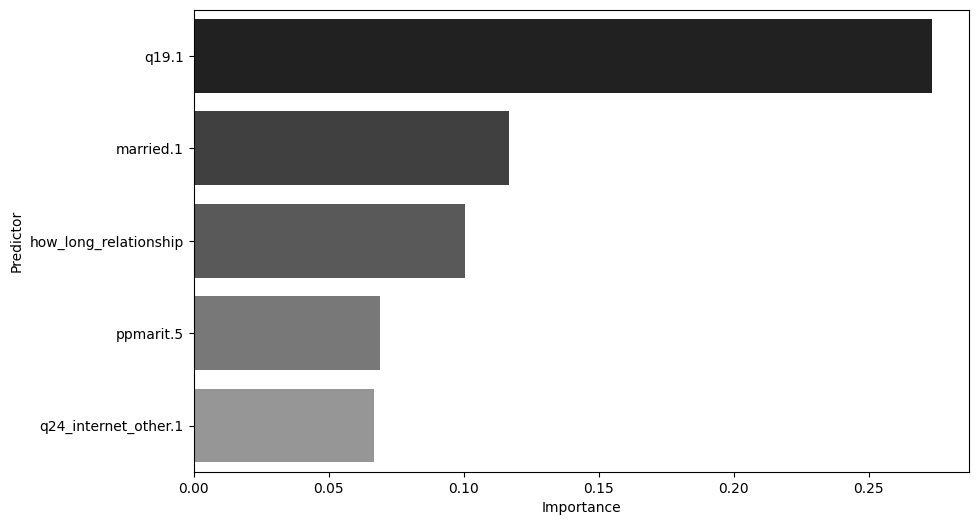

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files


feature_importances_df = pd.read_csv("/content/drive/MyDrive/thesis data/top_5_predictors.csv")

# Define a custom color palette with shades of grey

colors = ['#212121', '#404040', '#595959', '#787878', '#969696']

# Create a bar plot using seaborn with the custom color palette
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_df['Importance'], y=feature_importances_df['Predictor'], palette=colors)
plt.xlabel('Importance')
plt.ylabel('Predictor')

# Save the figure to Google Drive
plt.savefig("feature importance.png")
files.download("feature importance.png")

plt.show()
